In [3]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import numpy as np

from d_code.imaging.io import tifffile

from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns
import h5py
import re
import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import mlab
%matplotlib inline

import traces as tm
from scipy import signal


import seaborn as sns
sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


sns.set_palette("husl")
sns.set_style("white")
sns.set_context("notebook")
sns.set_style({'image.cmap': u'Greys_r'})



import warnings
warnings.filterwarnings('ignore')

#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())


def xticksInSec(ax,frameRate, secInterval, plotLengthInFrames):
    import numpy as np    
    plotLengthInFrames = int(plotLengthInFrames)
    secInterval = int(secInterval)
    xtickframetimes = np.arange(0, plotLengthInFrames, frameRate*secInterval)
    xtickssectimes = np.arange(0, plotLengthInFrames/frameRate, secInterval).astype(int)
    return ax.set_xticks(xtickframetimes),ax.set_xticklabels(xtickssectimes)


/Users/Stan/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1496370829.log


This non-commercial license of GraphLab Create for academic use is assigned to stanlp86@gmail.com and will expire on November 04, 2017.


In [4]:
basedir = '/Users/Stan/Desktop/' #'/Volumes/G-DRIVE PRO Thunderbolt/2017/'#

slice_ = 2
epoch_ = 1
experiment = 'sp041917a'
qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/{0}/'.format(experiment)
sframePath = basedir + '{0}/sframe_slice_{1}_processed'.format(experiment, slice_)
tifPath = basedir + '{0}/aligned/green/slice_{1}/'.format(experiment, slice_)
workflowDictPath = basedir + '{0}/workflow_dict_e1_slice{1}.dat'.format(experiment, slice_)
odorInfoPath = basedir + '{0}/odorInfo_e1.dat'.format(experiment)
metadataPath = basedir + '{0}/metadata/slice_{1}/{0}_e1_002_015_slice_{1}_channel_0.dat'.format(experiment, slice_)
h5path = basedir + '{0}/h5/'.format(experiment)
#maskPath = '/Users/Stan/Desktop/{0}/segmentation/{0}_slice_{1}_maskSoFar.dat'.format(experiment, slice_)


In [5]:
#open experiment
slicePath = basedir + '{0}/{0}_e1_slice_{1}.h5'.format(experiment, slice_)
with pd.HDFStore(slicePath, 'r+') as f:
    DF = f['{0}_slice_{1}'.format(experiment, slice_)] 

#resort so that odorID is consecutive for each trial
DF = DF.groupby(['trialID', 'odorID', 'Frame']).apply(lambda x: x.reset_index(drop = True))

# Filter called cells and make sure each odor presentation is the same length
DF = DF.loc[DF.Frame.isin(range(233))& DF.cellProbBinary==1,:]

numOdors = 23
trialSet = DF.trialID.unique()
cells = DF['cellID'].unique().shape[0]
frames =  DF.Frame.unique().shape[0]*numOdors
trials = len(trialSet)


In [110]:
# oidx = 3
# trial = 4
# odor3 = DF.loc[(slice(trial,trial,1), slice(oidx,oidx,1), slice(0,233,1)),'dFF'].unstack(None).values[:,:100]

# plt.plot(odor3);
# plt.ylim(-0.5,1)

### Load eegs for trials that have passed 

In [6]:

all_eegs = []
epochs = [(1, 'awake')]
for idx, state in epochs:
    
    trialIDsToUse = trialSet.copy()
    files = glob(h5path + '*.h5')
    h5Trials = [int(re.split('_00|.h5',files[i])[-2]) for i in range(len(files))]
    helper = []
    for i, trialID in enumerate(h5Trials):
        if trialID in list(trialIDsToUse):
            helper.append((i,trialID))
    for trialIDX, trialID in helper:

        eeg = h5py.File(files[trialIDX])
        
        all_eegs.append(eeg['trial_{0:04}'.format(trialID)][0])
        

In [7]:
downsample_fact = 10
all_eegs = [_[::downsample_fact] for idx, _ in enumerate(all_eegs)]

resampled_rate = 10000/downsample_fact

# subtract offset. 

for trial in range(len(all_eegs)):
    all_eegs[trial]= all_eegs[trial].copy()-all_eegs[trial].mean()
    
print len(all_eegs)

10


In [8]:
trialSet.shape

(7,)

In [11]:
a[1][25:31]

array([ 50.,  52.,  54.,  56.,  58.,  60.])

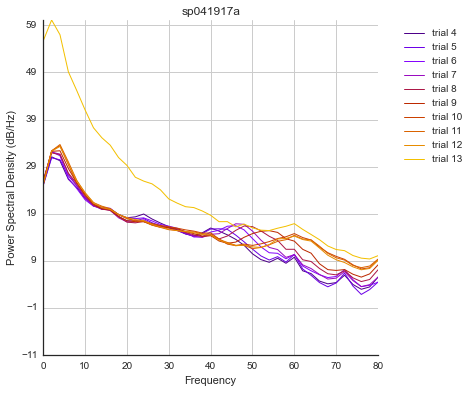

In [16]:

dgratio = []
gammaOnly = []
deltaOnly = []
colors = sns.color_palette('gnuplot',n_colors = trialSet.shape[0])#sns.cubehelix_palette(n_colors = 11, start = 1.6, rot = -1, light = 0.7, dark = 0.2, as_cmap = False )
#firstAnesthTrial = 13
fig, ax = plt.subplots(1,1, figsize = (6,6))


NFFT =500
for i in range(len(all_eegs)):
    
    #c = 'k'
    #label = 'awake'
#     if i>=firstAnesthTrial:
#         c=colors[1][0]
#         label = colors[1][1]
    a = ax.psd(all_eegs[i][100:], NFFT=NFFT, Fs=resampled_rate, detrend=mlab.detrend_linear,
    window=mlab.window_hanning, noverlap=50,
    scale_by_freq=True,linewidth = 1, color = colors[i], label = 'trial {}'.format(trialSet[i]))
    
    #frequencyBand
    #gamma: 50hz: a[1][25]
    #delta: 4 hz: a[1][2]
#     delta = a[0][3] # 1
#     gamma = a[0][25] 
    delta = 10*np.log10(a[0][2])
    gamma = 10*np.log10(a[0][22:35].mean())
    dgratio.append(delta/gamma)
    gammaOnly.append(gamma)
    deltaOnly.append(delta)
    da = deltaOnly/np.mean(deltaOnly)
    ga = gammaOnly/np.mean(gammaOnly)
    #dgratio.append(10*np.log10(delta/gamma))
    ax.set_xlim(0,80)
    #ax.set_ylim(10,55)
       
#     if i==0:
#         patchA = mpatches.Patch(color=c, label=label)
    
# plt.legend(handles=[patchA])
plt.legend(bbox_to_anchor=(1.05, 1),loc = 2)
ax.set_title(experiment)  
sns.despine(trim = False)    

plt.savefig(qcGitDir + 'eegSpecGram.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [13]:
len(all_eegs)

7

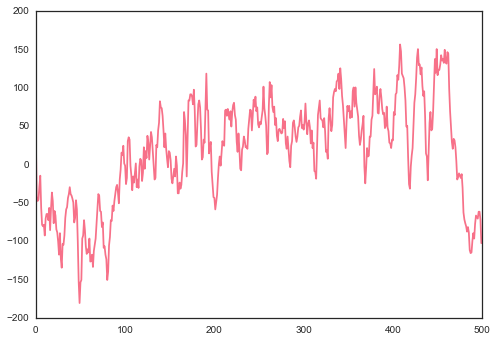

In [15]:
plt.plot(all_eegs[4][:500])

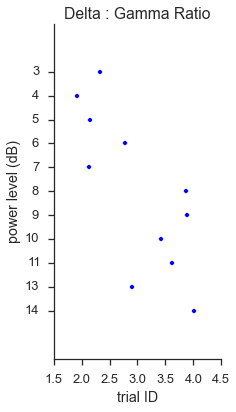

In [8]:

# # trial by trial depiction of delta:gamma power
# sns.set(style='ticks', context = 'talk', palette = 'muted')
# fig, ax = plt.subplots(1,1, figsize = (3,6))
# # ax.plot(range(firstAnesthTrial),dgratio[:firstAnesthTrial], '.k')
# # ax.plot(range(firstAnesthTrial,len(dgratio)),dgratio[firstAnesthTrial:], '.b')

# ax.scatter(dgratio[:], range(len(trialSet))[::-1])


# allTrialIDs = trialSet
# plt.setp(ax, title = 'Delta : Gamma Ratio',ylabel = 'power level (dB)', xlabel = 'trial ID',         
#          yticks = range(len(allTrialIDs)),yticklabels = allTrialIDs[::-1])

# sns.despine(trim = False)
# #plt.savefig(qcGitDir + 'deltaGammaRatio.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [ ]:
# odor 16 is a high density odor. a

In [ ]:
#odor set 1
# classes = dict(furans = [1,2,3,4],
#                 esters = [5,6,7],
#                 aldehydes = [8,9,10,11],
#                 ketones = [12,13,14],
#                 sulfurs = [15,16,17,18], # dense class
#                 acids = [19,20,21,22])

#odor set 2

#aldehydes is the dense class 6,7,8,9,10,11

In [9]:

#unstack by frame
unstackedByFrame = DF.dFF.unstack('Frame')

#select class of odors that recruits dense response.
samp = unstackedByFrame.loc[unstackedByFrame.index.get_level_values('odorID').isin(range(6,11)),unstackedByFrame.columns.isin(range(109,145))]

# Present trials in consecutive manner; as acquired
unsortedOdor16 = samp.mean(1).unstack('odorID').mean(1).unstack(-1)
# or sort:
eegContent = da/ga
joi = zip(trialSet,eegContent)
mostAwaketrialIDs = sorted(joi, key = lambda x: x[1])
sortedtrialIDs = [mostAwaketrialIDs[_][0] for _ in range(len(mostAwaketrialIDs))]
sortedOdor16 = samp.mean(1).unstack('odorID').mean(1).unstack(-1).reindex_axis(sortedtrialIDs)

In [21]:
np.percentile(unsortedOdor16.values,100)

0.40058748640590364

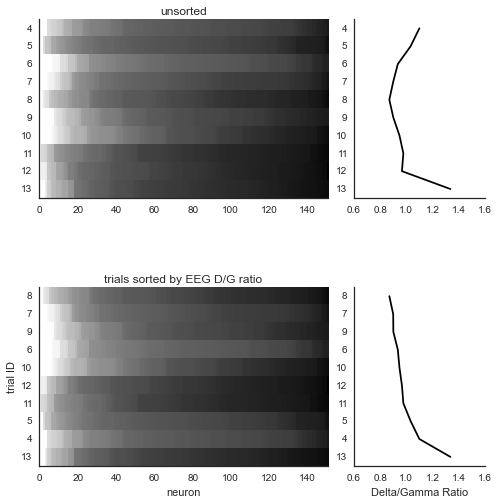

In [11]:
plt.figure(figsize = (8,8))
axF = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
axEEG = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=1)
axF2 = plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
axEEG2 = plt.subplot2grid((2,3), (1,2), colspan=1, rowspan=1)

ma = np.percentile(unsortedOdor16.values,98)
#plot normed fluorescence sorted by cell's response intensity  from highest to lowest to dense odor on that trial
axF.imshow(np.sort(unsortedOdor16.values)[:,::-1], aspect = 'auto',vmax = ma)
startInt = axF.get_yticks()[0]
stopInt = axF.get_yticks()[-1]
# now label fluorescence plot with trialID from top to bottom
tickLabels = unsortedOdor16.index.get_level_values(-1)
NumTrialsToTicks = range(len(unsortedOdor16.index.get_level_values(-1)))
plt.setp(axF,title = ('unsorted'), yticks = NumTrialsToTicks, yticklabels = tickLabels)
#plot eeg 
#need point locs to coincide with fluorescence plot on left 
# to calculate pointlocs, we need numtrials*2 or numtrials*2+1 equally spanning intervals  over the 
#ticks range of the flurescence plot

ytickIntervalsEEG = np.linspace(startInt,stopInt,num = len(trialSet)*2+1, endpoint=True, retstep = False)
plotLocsEEG = ytickIntervalsEEG[1::2][::-1]

axEEG.plot(eegContent[:], plotLocsEEG,'-k', markersize  = 6)
sns.despine()
#label ticks with trialID from top to bottom
#EEGTicks = [val-0.3 for val in NumTrialsToTicks]
asd = plt.setp(axEEG,      
                yticks = plotLocsEEG, yticklabels = tickLabels,  xlim = (0.6,1.6))


#plot normed fluorescence sorted by cell's response intensity  from highest to lowest to dense odor on that trial
axF2.imshow(np.sort(sortedOdor16.values)[:,::-1], aspect = 'auto',vmax = ma)
startInt = axF2.get_yticks()[0]
stopInt = axF2.get_yticks()[-1]
# now label fluorescence plot with trialID from top to bottom
tickLabels = sortedOdor16.index.get_level_values(-1)
NumTrialsToTicks = range(len(sortedOdor16.index.get_level_values(-1)))
plt.setp(axF2, title = ('trials sorted by EEG D/G ratio'), xlabel = 'neuron', ylabel = 'trial ID', yticks = NumTrialsToTicks, yticklabels = tickLabels)
#plot eeg 
#need point locs to coincide with fluorescence plot on left 
# to calculate pointlocs, we need numtrials*2 or numtrials*2+1 equally spanning intervals  over the 
#ticks range of the flurescence plot

ytickIntervalsEEG = np.linspace(startInt,stopInt,num = len(trialSet)*2+1, endpoint=True, retstep = False)
plotLocsEEG = ytickIntervalsEEG[1::2][::-1]

axEEG2.plot(np.sort(eegContent[:]), plotLocsEEG,'-k', markersize  = 6)
sns.despine()
#label ticks with trialID from top to bottom
#EEGTicks = [val-0.3 for val in NumTrialsToTicks]
asd = plt.setp(axEEG2, xlabel = 'Delta/Gamma Ratio',      
                yticks = plotLocsEEG, yticklabels = tickLabels, xlim = (0.6,1.6))
plt.savefig(qcGitDir + 'EEG+Fluor.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

# break down eeg by odor presentation

In [17]:
basedir = '/Users/Stan/Desktop/' #'/Volumes/G-DRIVE PRO Thunderbolt/2017/'
experiment = 'sp041917a'
slice_ = 2
epoch = 1
suite2pPath = basedir + '{0}/{0}_e{1}_slice_{2}_v2.h5'.format(experiment, epoch, slice_)

In [18]:
with pd.HDFStore(suite2pPath) as f:
    print f.keys()
    #suiteDF = f['{0}_slice_{1}'.format(experiment, slice_)]
    tifinfo = f['tifInfo_slice_{0}'.format(slice_)]

['/sp041917a_slice_2', '/tifInfo_slice_2']


In [19]:
odorNamePath = basedir + '{0}/e{1}_odor_order_odorlist.csv'.format(experiment, epoch)

odorInfo = pd.DataFrame.from_csv(odorNamePath)


In [20]:
odorInfo.iloc[17]

name    propanoicAcid
Name: 18, dtype: object

In [21]:
#odorID = 17
trialSet = [4,5,6,7,8,9,10,11,12,13]
#metafiles = tifinfo.loc[tifinfo.odorID == odorID, 'metadataFname'].values
eegfiles = glob(h5path + '*.h5')

sampRate = 10000
downsample_fact = 10
resampled_rate = 10000/downsample_fact

allODorswithAllTrials = []
for odorID in range(1,24):
    metafiles = tifinfo.loc[tifinfo.odorID == odorID, 'metadataFname'].values

    eegSegmentsThisOdorAllTrials = []
    for trialID in trialSet:
        fname = [fname for fname in metafiles if '_e1_{:03}'.format(trialID) in fname][0]
        metaFnameEnd = re.split('/',fname)[-1]
        metaFname = basedir + '{0}/metadata/slice_{1}/'.format(experiment, slice_) + metaFnameEnd
        #print metaFname
        metadf = pickle.load(open(metaFname))

        #in seconds start of odor presentation over interval that initiates with trial start and ends with trial stop. 
        trialRefStartforOdor = metadf['FrameTimestamp(s)'].iloc[0]
        trialRefStopforOdor = metadf['FrameTimestamp(s)'].iloc[-1]
        #print trialRefStartforOdor,trialRefStopforOdor
        # now read corresponding eeg segment

        eegFname = [fname for fname in eegfiles if 'e1_{:04}'.format(trialID) in fname][0]
        #print eegFname
        #print '\n'
        with h5py.File(eegFname) as f:
            eegSignal = f['trial_{0:04}'.format(trialID)][0]


        eegStart = int(np.ceil(trialRefStartforOdor*sampRate))
        eegStop = int(np.ceil(trialRefStopforOdor*sampRate))
        eegSegmentsThisOdorAllTrials.append(eegSignal[eegStart:eegStop][::downsample_fact])
    allODorswithAllTrials.append(eegSegmentsThisOdorAllTrials)


In [ ]:
fname

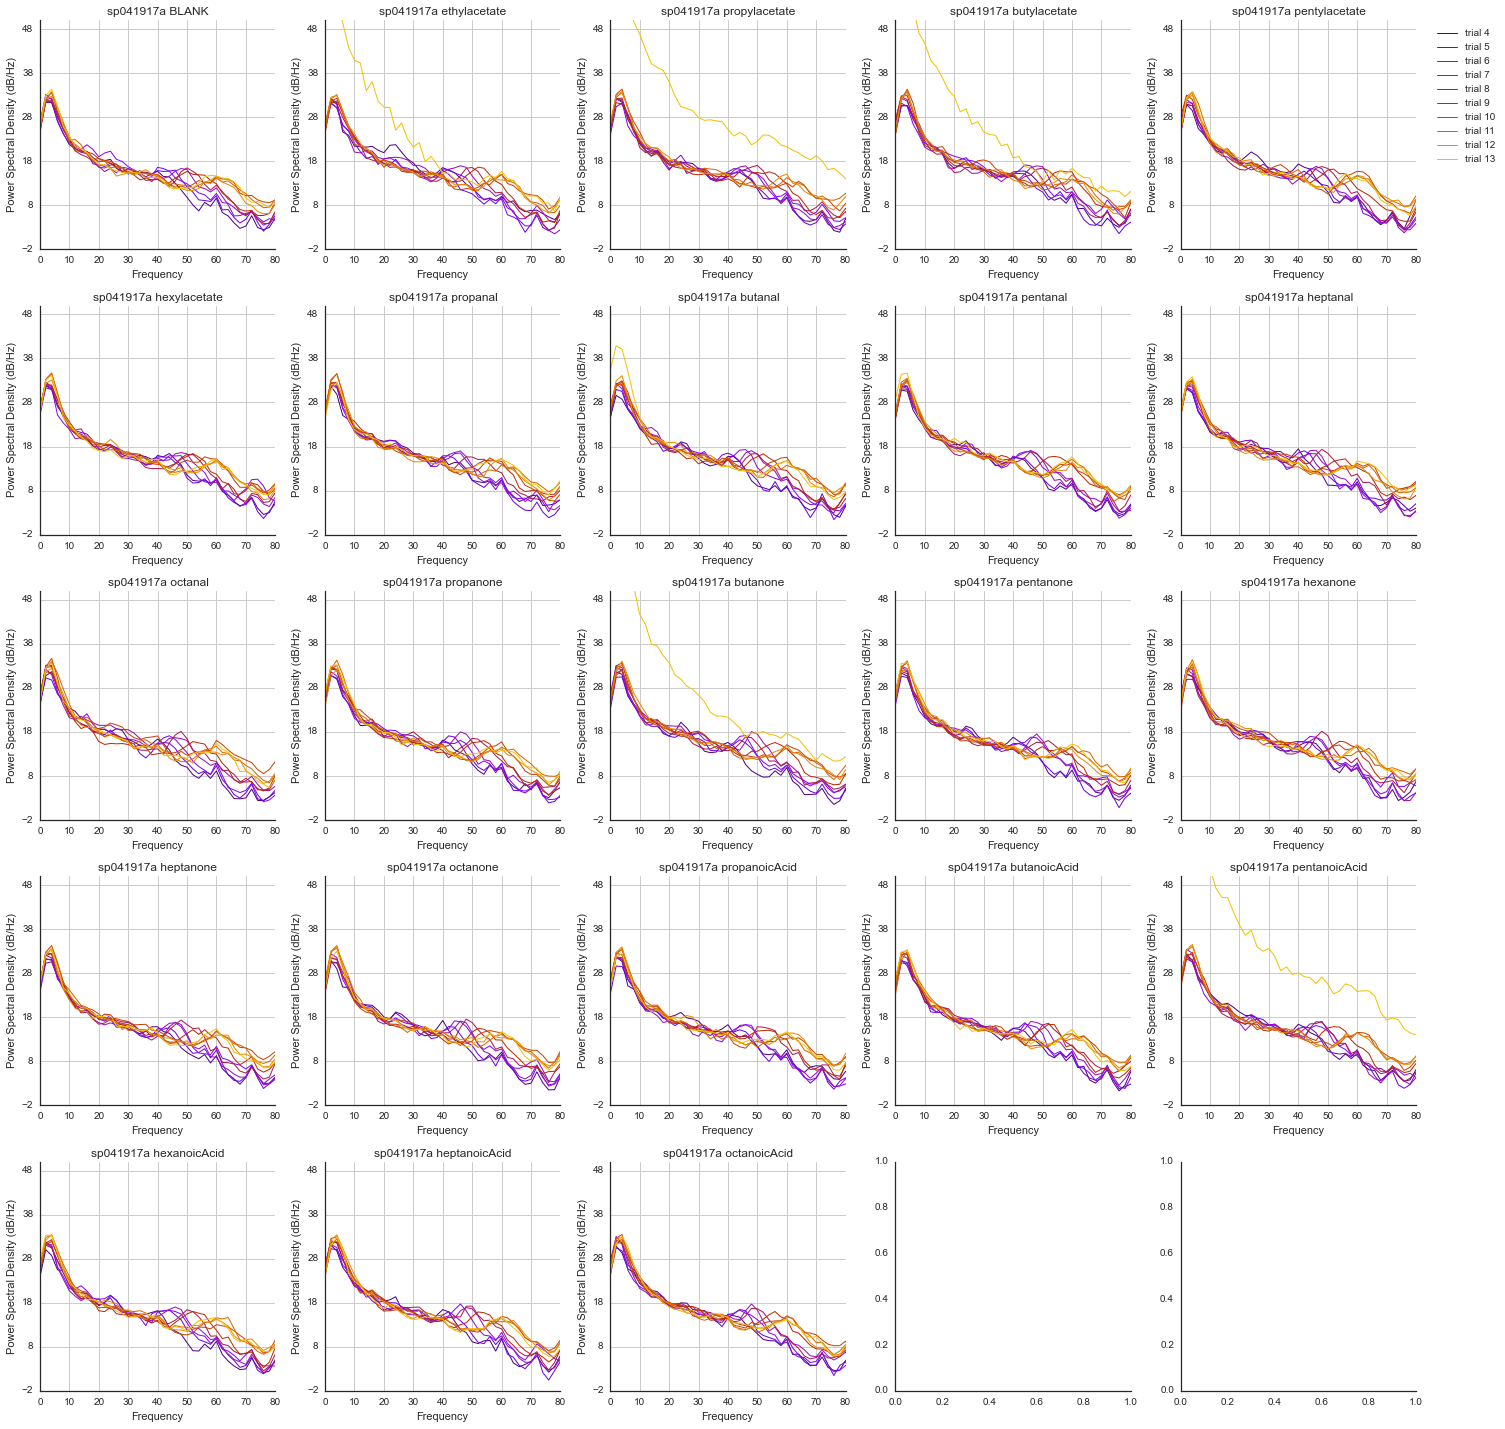

In [23]:

dgratio = []
gammaOnly = []
deltaOnly = []
colors = sns.color_palette('gnuplot',n_colors = len(trialSet))#sns.cubehelix_palette(n_colors = 11, start = 1.6, rot = -1, light = 0.7, dark = 0.2, as_cmap = False )
NFFT =500

fig, ax = plt.subplots(5,5, figsize = (20,20))
ax = ax.ravel()

for odor, odorID in enumerate(range(1,24)):

    for i in range(len(allODorswithAllTrials[odor])):

            #c = 'k'
            #label = 'awake'
        #     if i>=firstAnesthTrial:
        #         c=colors[1][0]
        #         label = colors[1][1]
            a = ax[odor].psd(allODorswithAllTrials[odor][i][:], NFFT=NFFT, Fs=resampled_rate, detrend=mlab.detrend_linear,
            window=mlab.window_hanning, noverlap=50,
            scale_by_freq=True,linewidth = 1, color = colors[i], label = 'trial {}'.format(trialSet[i]))

            #frequencyBand
            #gamma: 50hz: a[1][25]
            #delta: 4 hz: a[1][2]
        #     delta = a[0][3] # 1
        #     gamma = a[0][25] 
            delta = 10*np.log10(a[0][2])
            gamma = 10*np.log10(a[0][25:31].mean())
            dgratio.append(delta/gamma)
            gammaOnly.append(gamma)
            deltaOnly.append(delta)
            da = deltaOnly/np.mean(deltaOnly)
            ga = gammaOnly/np.mean(gammaOnly)
            #dgratio.append(10*np.log10(delta/gamma))
            ax[odor].set_xlim(0,80)
            ax[odor].set_ylim(-2,50)
            ax[odor].set_title(experiment + ' {}'.format(odorInfo.loc[odorID,'name']))  
            sns.despine(trim = False)   
            if odor == 4:
                ax[4].legend(bbox_to_anchor=(1.05, 1),loc = 2)

plt.tight_layout()

plt.savefig(qcGitDir + 'eegSpecGramByOdor.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

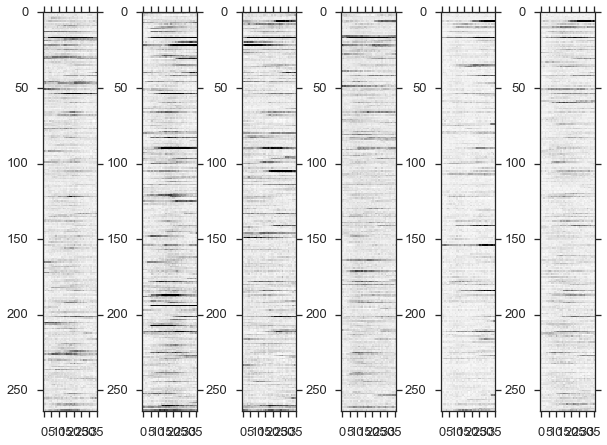

In [498]:
fig, ax = plt.subplots(1,6)
ax = ax.ravel()
for i, trial in enumerate([5,6,7,8,11,12]):

    ax[i].imshow(samp.loc[trial,16, :], vmax = .5)

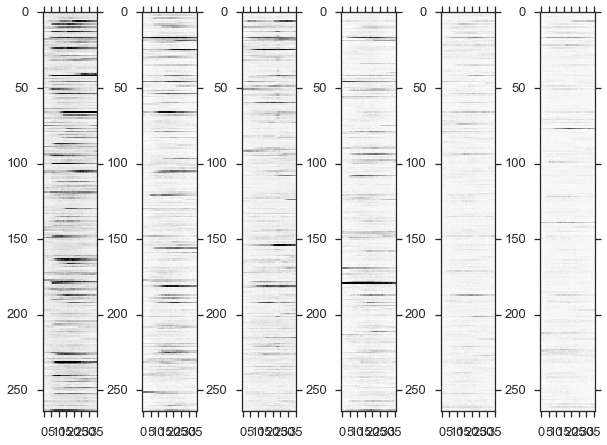

In [497]:
fig, ax = plt.subplots(1,6)
ax = ax.ravel()
for i, trial in enumerate([1,2,3,4,9,10]):

    ax[i].imshow(samp.loc[trial,16, :],vmax = 1)

In [ ]:
#measure trial to trial reliability across the 1 threshold. 

Load movies 

In [112]:
fnames = glob('/Users/Stan/Desktop/sp042616a/h5/green/*.h5')

In [125]:
def convertMov(fname, bounds = None, manualBounds = None):
    eID, trialID = [int(_) for _ in re.split('_e|_0|_con',fname)[-3:-1]]
    
    
    with h5py.File(fname,'r') as f:
        mov = f['current_statestep2/corrected'][...]
    if bounds != None:
        minval,maxval = bounds
        minval = np.percentile(mov, minval)
        maxval = np.percentile(mov, maxval)

        mov[mov<minval] = minval
        mov[mov>maxval]=maxval

    elif manualBounds != None:
        manualMin, manualMax = manualBounds
        mov[mov<manualMin] = manualMin
        mov[mov>manualMax]= manualMax
    
    io.imsave(mov, '/users/stan/desktop/e{0}_{1}.tif'.format(eID, trialID))
    return 'saved'

In [137]:
[convertMov(fname,bounds = [5,100]) for fname in fnames]

['saved', 'saved', 'saved', 'saved', 'saved', 'saved', 'saved', 'saved']

In [231]:
for fname in fnames:
    with h5py.File(fname,'r') as f:
        mov = f['current_statestep2/corrected'][10:-10,10:-10,:]
    print fname
    print np.mean(mov)#np.percentile(mov, 5), np.percentile(mov, 100)

/Users/Stan/Desktop/sp042616a/h5/green/_e1_006_concatenated.h5
22003.7398237
/Users/Stan/Desktop/sp042616a/h5/green/_e1_009_concatenated.h5
22005.2861578
/Users/Stan/Desktop/sp042616a/h5/green/_e1_014_concatenated.h5
21998.9108454
/Users/Stan/Desktop/sp042616a/h5/green/_e1_019_concatenated.h5
21956.9131908
/Users/Stan/Desktop/sp042616a/h5/green/_e2_004_concatenated.h5
21916.1953828
/Users/Stan/Desktop/sp042616a/h5/green/_e2_009_concatenated.h5
21917.9869933
/Users/Stan/Desktop/sp042616a/h5/green/_e2_011_concatenated.h5
21936.3408663
/Users/Stan/Desktop/sp042616a/h5/green/_e2_014_concatenated.h5
21946.5087284


---
### Load raw traces

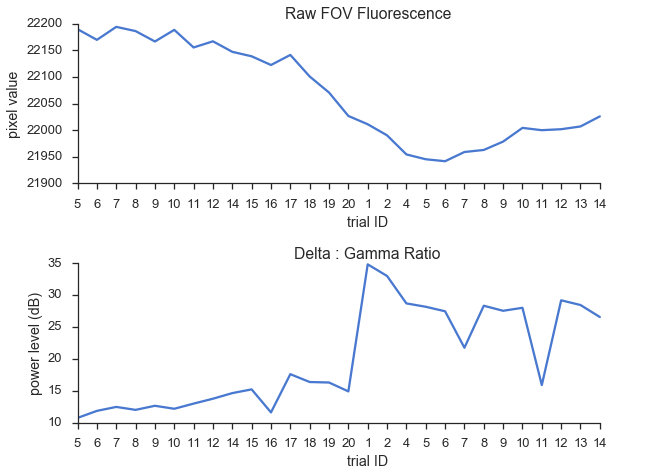

In [153]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(works.values)
plt.setp(ax1, title = 'Raw FOV Fluorescence',ylabel = 'pixel value', xlabel = 'trial ID',         
         xticks = range(len(allTrialIDs)),xticklabels = list(awakeTrialIDs)+list(anesthetizedTrialIDs))
ax2.plot(dgratio)
plt.setp(ax2, title = 'Delta : Gamma Ratio',ylabel = 'power level (dB)', xlabel = 'trial ID',         
         xticks = range(len(allTrialIDs)),xticklabels = list(awakeTrialIDs)+list(anesthetizedTrialIDs))

sns.despine(trim = True)

In [155]:
len(dgratio)

28

[<matplotlib.text.Text at 0x1380b3b50>, <matplotlib.text.Text at 0x136d36cd0>]

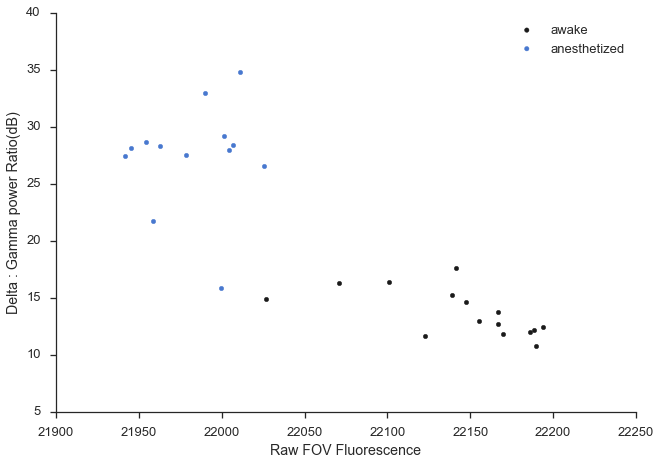

In [180]:
fig, ax = plt.subplots(1,1)
ax.scatter(list(works.values)[:15],dgratio[:15], color = 'k', label = 'awake')
ax.scatter(list(works.values)[15:],dgratio[15:], color = 'b', label = 'anesthetized')
sns.despine()
plt.legend()

plt.setp(ax,ylabel = 'Delta : Gamma power Ratio(dB)', xlabel = 'Raw FOV Fluorescence')


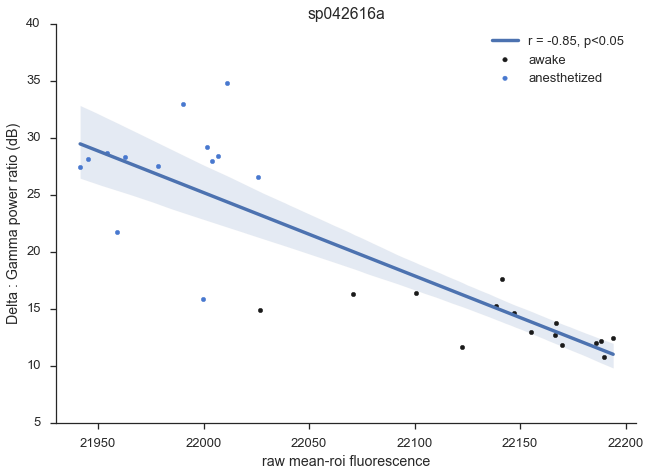

In [232]:
sns.set(style = 'ticks',context = 'talk')
ax = sns.regplot(x=works.values, y=np.asarray(dgratio), fit_reg = True, truncate = True, ci=95, scatter = False, label = 'r = -0.85, p<0.05')
ax.scatter(list(works.values)[:15],dgratio[:15], color = 'k', label = 'awake')
ax.scatter(list(works.values)[15:],dgratio[15:], color = 'b', label = 'anesthetized')
ax.legend()
plt.setp(ax, title = experiment, ylabel = 'Delta : Gamma power ratio (dB)', xlabel = 'raw mean-roi fluorescence',         
         xlim = (21930,22205))
sns.despine()
plt.savefig('/Users/Stan/Desktop/eegs2/regressionFvsEEG{}'.format(experiment), dpi = 100)

In [ ]:
a = plt.psd(all_eegs[19][100:], NFFT=NFFT, Fs=resampled_rate, detrend=mlab.detrend_linear,
    window=mlab.window_hanning, noverlap=50,
    scale_by_freq=True)
delta = a[0][1]
gamma = a[0][28]

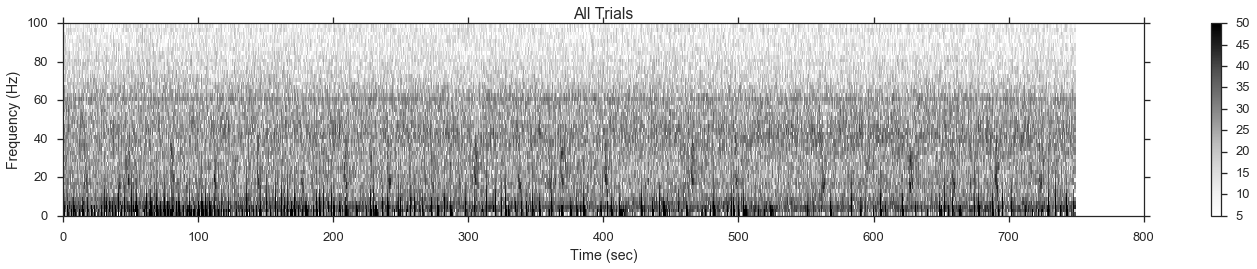

In [41]:
# inspect by trial
eeg = np.hstack(all_eegs[0])
x = resampled_rate/1000
eeg=eeg[::x]
fs_Hz= 1000
NFFT = 500  # pitck the length of the fft
FFTstep = 50
overlap = 50  # half-second steps
f_lim_Hz = [0, 100]   # frequency limits for plotting

data = eeg-eeg.mean()

spec_PSDperHz, freqs, t = mlab.specgram(data,
                           NFFT=NFFT,
                           window=mlab.window_hanning,
                           Fs=fs_Hz,
                           noverlap=overlap
                           ) # returns PSD power per Hz
spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)  #convert to "per bin"
plt.figure(figsize = (20,4))
plt.pcolor(t, freqs, 10*np.log10(spec_PSDperBin))  # dB re: 1 uV
plt.clim([5, 50])
#plt.xlim(t[0], t[-1])
#plt.ylim([0,10])
#plt.ylim([0, fs_Hz/4.0])  # show the full frequency content of the signal
plt.ylim(f_lim_Hz)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

#     # add annotation for FFT Parameters
#     ax.text(0.025, 0.95,
#         "NFFT = " + str(NFFT) + "\nfs = " + str(int(fs_Hz)) + " Hz",
#         transform=ax.transAxes,
#         verticalalignment='top',a
#         horizontalalignment='left',
#         backgroundcolor='w')
plt.colorbar()
plt.title('All Trials')
plt.tight_layout()

#pylab.savefig(directory + 'full_eeg.png', dpi = 300,bbox_inches='tight')
#plt.close()
